In [25]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    min_distance = 0.5  # Minimum distance constraint
    
    for i in range(num_points):
        # Generate the points in different locations to unbias learning
        x_beginning = None
        y_beginning = None
        if i % 4 == 0:
            x_beginning = 0
            y_beginning = 0
        elif i % 4 == 1:
            x_beginning = 1
            y_beginning = 0
        elif i % 4 == 2:
            x_beginning = 0
            y_beginning = 1
        else:
            x_beginning = 1
            y_beginning = 1

        data_point = []
        positions = []

        # Generate 3 particles with unique positions separated by at least 0.1
        for _ in range(3):
            while True:
                x = np.random.uniform(x_beginning, x_beginning + 1)
                y = np.random.uniform(y_beginning, y_beginning + 1)
                position = (x, y)

                # Check distance against all existing particles
                if all(np.sqrt((x - px)**2 + (y - py)**2) >= min_distance for px, py in positions):
                    positions.append(position)
                    break
            
            mass = np.random.uniform(1, 6)
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 10000 data points
num_points = 10000
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.132686, y = 0.223230, mass = 5.9651, force = [2.031662e+01, 5.410946e+01]]
  Particle 2: [x = 0.193014, y = 0.802181, mass = 2.4112, force = [1.041201e+01, -4.346992e+01]]
  Particle 3: [x = 0.835386, y = 0.748046, mass = 2.5618, force = [-3.072863e+01, -1.063954e+01]]

Data point 2:
  Particle 1: [x = 1.677738, y = 0.856820, mass = 5.4999, force = [-7.060767e+01, -8.786853e+01]]
  Particle 2: [x = 1.452638, y = 0.231168, mass = 5.3897, force = [-6.937027e+01, 1.212259e+02]]
  Particle 3: [x = 1.009313, y = 0.511104, mass = 5.5538, force = [1.399779e+02, -3.335741e+01]]

Data point 3:
  Particle 1: [x = 0.119607, y = 1.919582, mass = 5.6533, force = [4.693618e+01, -2.110299e+01]]
  Particle 2: [x = 0.951596, y = 1.309074, mass = 2.3653, force = [-2.023194e+01, 2.045725e+01]]
  Particle 3: [x = 0.623008, y = 1.732589, mass = 2.0032, force = [-2.670424e+01, 6.457382e-01]]



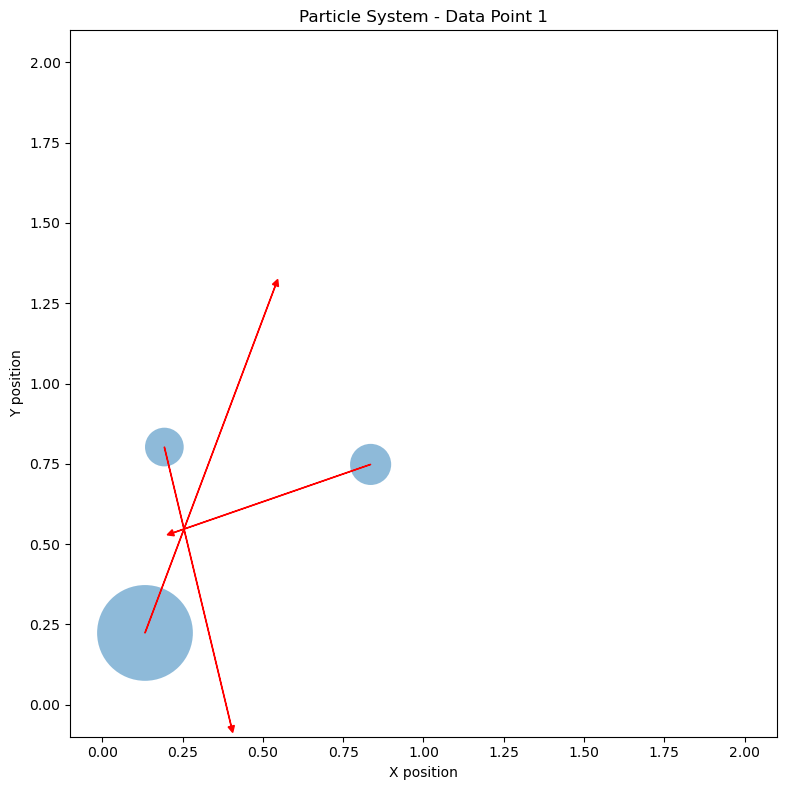

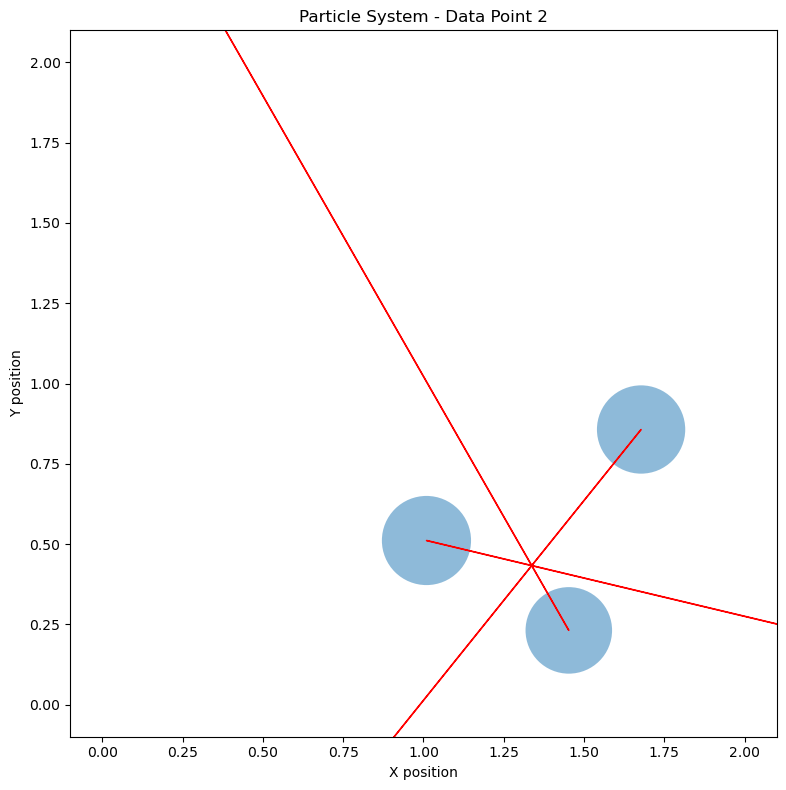

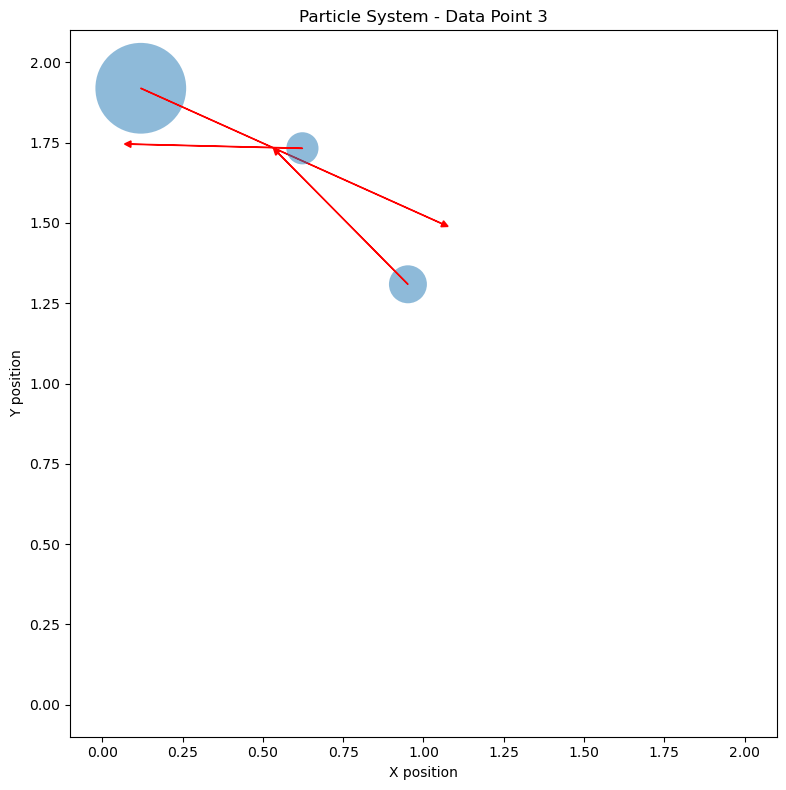

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(-0.1, 2.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = mass / 40  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 64),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        out = self.mlp(tmp)
        return out

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        return edge_attr

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.2563, 0.6871, 0.6568],
        [0.9449, 0.8404, 0.8270],
        [0.3520, 0.3234, 0.1433]])
Input:
tensor([[0.2563, 0.6871, 0.6568],
        [0.9449, 0.8404, 0.8270],
        [0.3520, 0.3234, 0.1433]])

Output (forces):
tensor([[0.1798, 0.0208],
        [0.1774, 0.0234],
        [0.1778, 0.0204]], grad_fn=<ScatterAddBackward0>)


In [28]:
# Initialize datasets for input features (x_dataset) and labels/outputs (y_dataset).
x_dataset = []
y_dataset = []

# Define the edge connections (fully connected graph for 3 nodes).
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)

# Process each data point in the particle dataset.
for data_point in particle_dataset:
    # Extract features (first 3 values) and labels (4th value) for all particles.
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)

    # Add graph data and corresponding labels to datasets.
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)

# Print first two raw data points from the dataset for verification.
for particle in particle_dataset[:2]:
    print(particle)

print("\n")

# Print features (x) of the first two graphs in the dataset.
for x in x_dataset[:2]:
    print(x.x)

print("\n")


# Print labels (y) of the first two data points.
for y in y_dataset[:2]:
    print(y)

[[0.1326862783052768, 0.2232303903959889, 5.965103055132454, [20.31662146596301, 54.10946364201359]], [0.19301395681895717, 0.8021806078214064, 2.41121311177753, [10.41200914936945, -43.469919917720404]], [0.8353860745155188, 0.748046472289941, 2.561825234114012, [-30.728630615332456, -10.63954372429318]]]
[[1.6777377802208444, 0.8568196312554054, 5.499911149677013, [-70.60766894067555, -87.86852608877777]], [1.452638469506284, 0.23116795627190012, 5.389691516598087, [-69.3702726840912, 121.22593997476017]], [1.0093126041317382, 0.5111039633752733, 5.553829866289457, [139.97794162476674, -33.357413885982396]]]


tensor([[0.1327, 0.2232, 5.9651],
        [0.1930, 0.8022, 2.4112],
        [0.8354, 0.7480, 2.5618]])
tensor([[1.6777, 0.8568, 5.4999],
        [1.4526, 0.2312, 5.3897],
        [1.0093, 0.5111, 5.5538]])


tensor([[ 20.3166,  54.1095],
        [ 10.4120, -43.4699],
        [-30.7286, -10.6395]])
tensor([[-70.6077, -87.8685],
        [-69.3703, 121.2259],
        [139.9779, -3

Using device: cuda
Epoch [1/100], Loss: 765.1307, Learning Rate: 0.0200000000
Epoch [2/100], Loss: 100.4092, Learning Rate: 0.0200000000
Epoch [3/100], Loss: 34.2554, Learning Rate: 0.0200000000
Epoch [4/100], Loss: 14.5139, Learning Rate: 0.0200000000
Epoch [5/100], Loss: 18.1542, Learning Rate: 0.0200000000
Epoch [6/100], Loss: 11.0159, Learning Rate: 0.0200000000
Epoch [7/100], Loss: 16.9647, Learning Rate: 0.0200000000
Epoch [8/100], Loss: 13.6189, Learning Rate: 0.0200000000
Epoch [9/100], Loss: 9.4844, Learning Rate: 0.0200000000
Epoch [10/100], Loss: 10.8027, Learning Rate: 0.0180000000
Epoch [11/100], Loss: 11.6511, Learning Rate: 0.0180000000
Epoch [12/100], Loss: 11.9578, Learning Rate: 0.0180000000
Epoch [13/100], Loss: 10.4587, Learning Rate: 0.0180000000
Epoch [14/100], Loss: 3.5935, Learning Rate: 0.0180000000
Epoch [15/100], Loss: 4.0596, Learning Rate: 0.0180000000
Epoch [16/100], Loss: 9.9688, Learning Rate: 0.0180000000
Epoch [17/100], Loss: 10.2869, Learning Rate: 0.

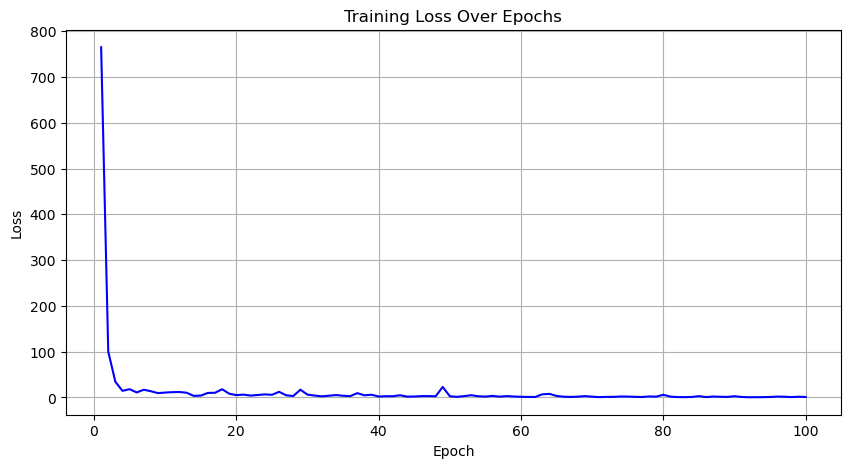

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Create a custom dataset that combines x (graph data) and y (labels)
class GraphDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data  # List of torch_geometric.data.Data objects
        self.y_data = y_data  # Corresponding labels

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]  # Get the graph data
        y = self.y_data[idx]  # Get the corresponding label
        x.y = y  # Assign the label to the graph data object
        return x

# Initialize the custom dataset
dataset = GraphDataset(x_dataset, y_dataset)

# Train-test split
train_size = 0.8  # Define the proportion of training data
x_train, x_test, y_train, y_test = train_test_split(
    dataset.x_data, dataset.y_data, train_size=train_size, random_state=42
)

# Create training and testing datasets
train_dataset = GraphDataset(x_train, y_train)
test_dataset = GraphDataset(x_test, y_test)

# Use PyTorch Geometric DataLoader to load data in batches
batch_size = 64  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)  # Reduce LR by factor of gamma every step_size epochs

# Training loop
num_epochs = 100  # Define the number of epochs
loss_values = []  # List to store loss values for each epoch

for epoch in range(num_epochs):
    model.train()
    
    # Training phase
    epoch_loss = 0.0  # Initialize epoch loss
    for batch in train_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate epoch loss
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)  # Store the average loss
    
    # Update the learning rate
    scheduler.step()  # Call the scheduler step at the end of each epoch
    
    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.10f}')

print("Training complete!")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, color='b', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [30]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test loss and metrics
test_loss = 0.0  # Total loss over the test set
test_samples = 0  # Total number of samples

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        test_loss += loss.item() * batch.num_graphs  # Sum up batch loss, multiplied by number of graphs in the batch
        test_samples += batch.num_graphs  # Accumulate the total number of graphs

# Calculate the average test loss
avg_test_loss = test_loss / test_samples

print(f'Average Test Loss: {avg_test_loss:.4f}')

Average Test Loss: 0.5444


In [31]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device if not already done
model = model.to(device)

# Prepare to store predictions
predicted_forces = []

# Iterate through the dataset to predict forces
for x in x_dataset:
    # Move data to the device
    x = x.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(x)
        predicted_forces.append(output.cpu().numpy())

# Convert predicted forces to a format suitable for plotting
predicted_particle_dataset = []
for i, data_point in enumerate(particle_dataset[:6]):
    predicted_data_point = []
    for j, particle in enumerate(data_point):
        predicted_force = predicted_forces[i][j]  # Get predicted force
        particle_with_predicted_force = [particle[0], particle[1], particle[2], predicted_force.tolist()]
        predicted_data_point.append(particle_with_predicted_force)
    predicted_particle_dataset.append(predicted_data_point)

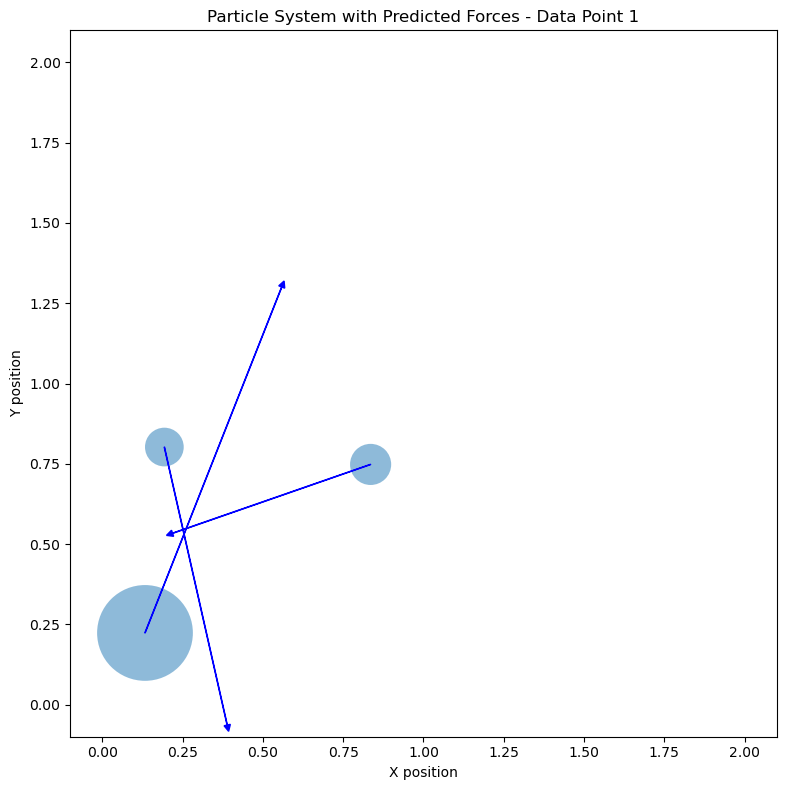

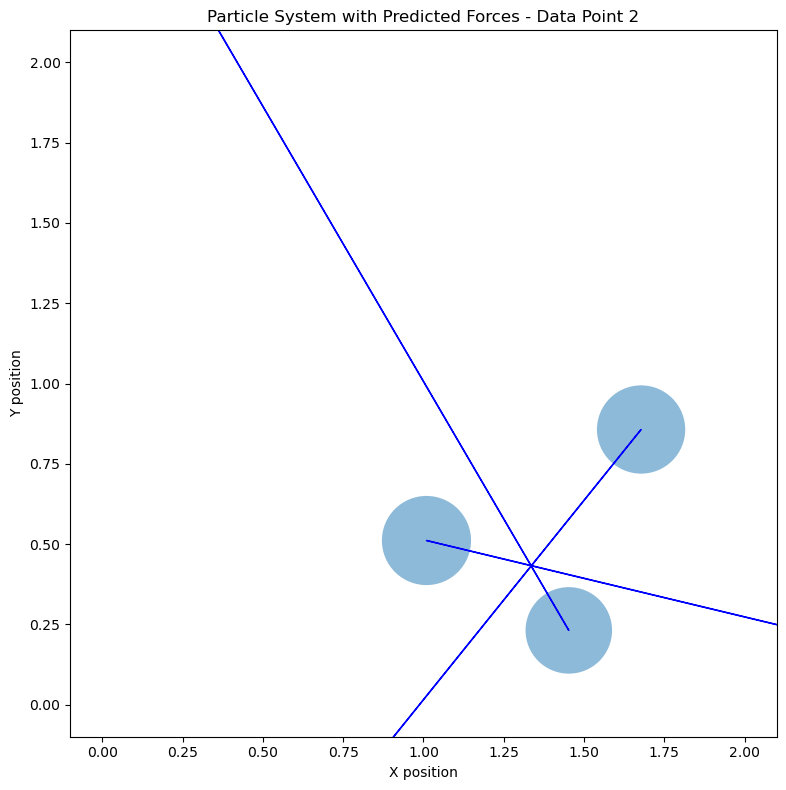

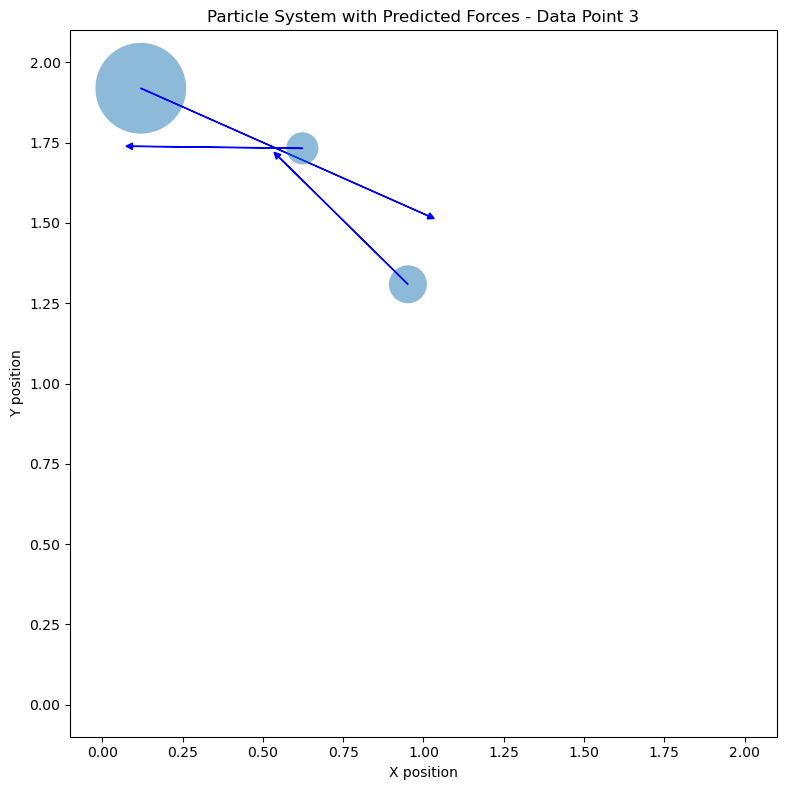

In [32]:
def plot_predicted_forces(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(-0.1, 2.1)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = mass / 40  # Scale radius
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot predicted force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                 head_width=0.02, head_length=0.02, fc='b', ec='b')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System with Predicted Forces - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Plot the predicted forces for the first 3 data points
for i, data_point in enumerate(predicted_particle_dataset[:3]):
    plot_predicted_forces(data_point, i + 1)

In [33]:
# Organize the data for PySR
input_data = []
predicted_forces = []
for i, data_point in enumerate(particle_dataset[:1000]):
    for j in range(0, 3):
        for k in range(0, 3):
            if j != k:
                particleA = data_point[j][:3]
                particleB = data_point[k][:3]
                input_tensor = torch.tensor(particleA + particleB, dtype=torch.float32)
                input_data.append(input_tensor)
                predicted_forces.append(model.edge_model.mlp(input_tensor.cuda()))

# Convert lists to NumPy arrays
input_data = np.vstack(input_data)
predicted_forces = np.vstack([tensor.cpu().detach().numpy() for tensor in predicted_forces])

<Figure size 640x480 with 0 Axes>

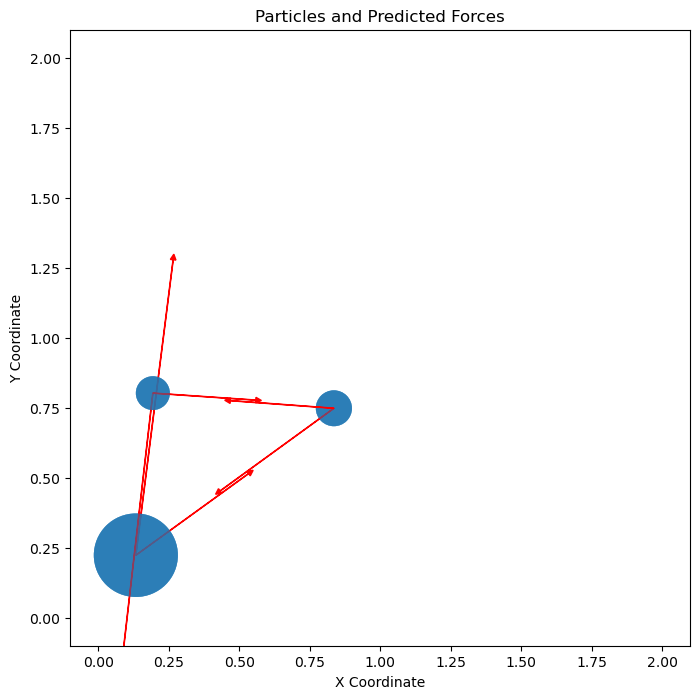

<Figure size 640x480 with 0 Axes>

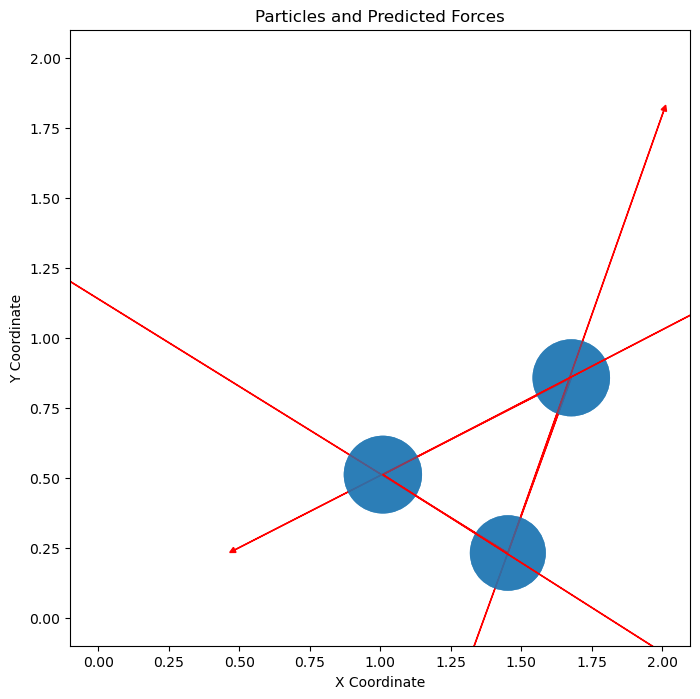

<Figure size 640x480 with 0 Axes>

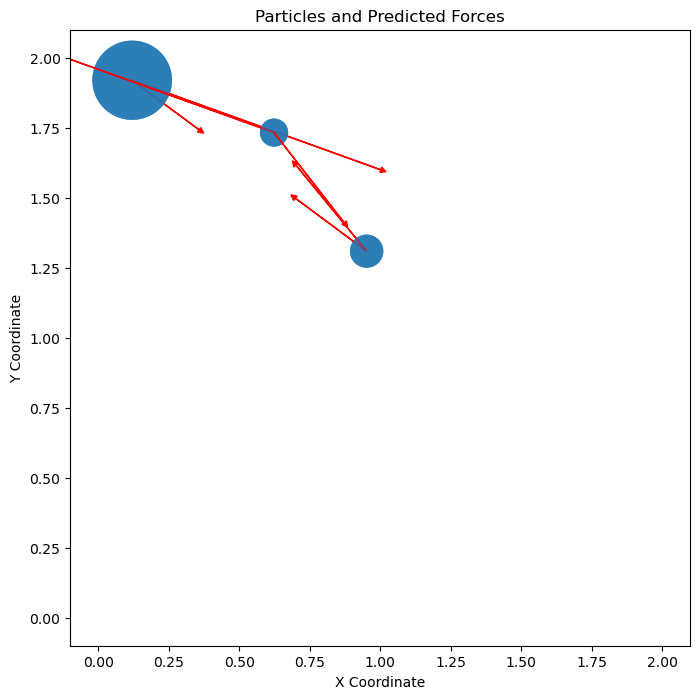

<Figure size 640x480 with 0 Axes>

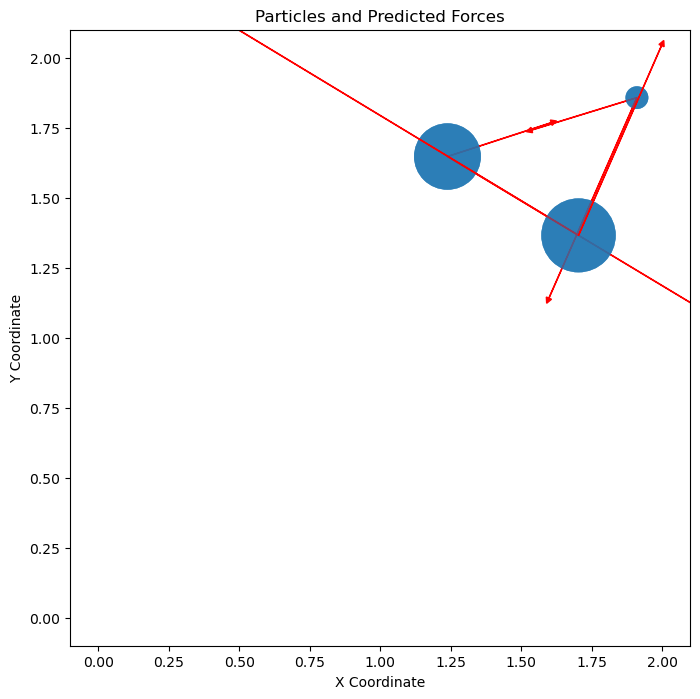

<Figure size 640x480 with 0 Axes>

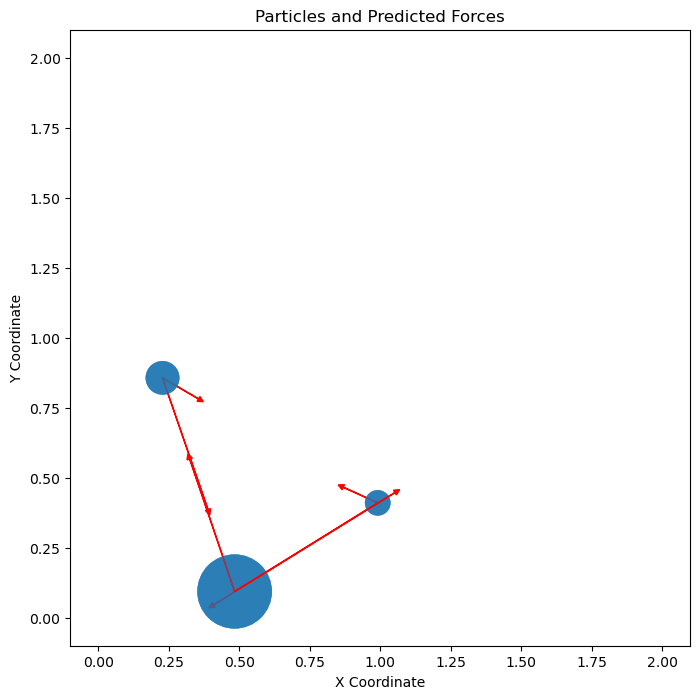

In [34]:
# Sample input data and predicted forces from the provided examples
n_samples = 30
input_data_sample = input_data[:n_samples]  # Extracting the first n_samples samples
predicted_forces_sample = predicted_forces[:n_samples]  # Extracting the first n_samples predicted forces


for k in range(0, len(input_data_sample), 6):
    # Create a new figure for each plot
    plt.figure()
    plt.figure(figsize=(8, 8))

    for i in range(k, k + 6):

        # Set plot limits
        plt.xlim(-0.1, 2.1)
        plt.ylim(-0.1, 2.1)

        # Extract particle data
        x1, y1, mass1, x2, y2, mass2 = input_data_sample[i]
        Fx, Fy = predicted_forces_sample[i]

        # Calculate the magnitude of the force
        force_magnitude = np.sqrt(Fx**2 + Fy**2)
        
        # Plot particles as a circles
        radius = mass1 / 40
        circle = plt.Circle((x1, y1), radius=radius, fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        radius = mass2 / 40
        circle = plt.Circle((x2, y2), radius=radius, fill=True, alpha=0.5)
        plt.gca().add_artist(circle)

        # Scale down the force arrow for visibility
        scale_factor = 0.1  # Adjust this value to change the arrow size

        # Draw force vector on Particle A (scaled down)
        plt.arrow(x1, y1, Fx / 40, Fy / 40, 
                head_width=0.02, head_length=0.02, fc='r', ec='r')

    # Set plot properties
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Particles and Predicted Forces')
    plt.show()

In [35]:
# Add a new column to the input data with the distances between particles
distances = []
for i in range(len(input_data)):
    x1, y1, mass1, x2, y2, mass2 = input_data[i]
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    distances.append(distance)

# Convert distances to a numpy array and add as a new column
distances = np.array(distances).reshape(-1, 1)
input_data_with_distances = np.hstack((input_data, distances))

In [36]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "-","*", "/"],
    unary_operators=["sqrt"],
)

model.fit(input_data_with_distances[:5000], predicted_forces[:5000])